In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
plt.rcParams["grid.linewidth"] = 0.2
pd.set_option("display.max_rows", 500)

layout_template = go.layout.Template(
    layout=go.Layout(
        font=dict(size=24),
        legend=dict(font_size=20),
        plot_bgcolor="white",
        xaxis=dict(
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
            linewidth=1.5,
            gridcolor="lightgrey",
            gridwidth=1,
            tickfont_size=20,
        ),
        yaxis=dict(
            mirror=True,
            ticks="outside",
            showline=True,
            linecolor="black",
            linewidth=1.5,
            gridcolor="lightgrey",
            gridwidth=1,
            tickfont_size=20,
        ),
    ),
)

## Load results

In [2]:
df_spglib = pd.read_json("stats_spglib.json").set_index("id")
df_moyopy = pd.read_json("stats_moyopy.json").set_index("id")

In [3]:
df = pd.merge(
    df_spglib, df_moyopy[["time_moyopy", "number_moyopy"]], left_index=True, right_index=True
)
df.sort_values(["material_id", "symprec"], inplace=True)

In [4]:
series_moyopy = df.groupby("material_id")["number_moyopy"].apply(list)
series_spglib = df.groupby("material_id")["number_spglib"].apply(list)

df_stat = pd.concat([series_moyopy, series_spglib], axis=1)
# jaccard_index(A, B) := |A ∩ B| / |A ∪ B|
df_stat["jaccard"] = df_stat.apply(
    lambda row: len(set(row["number_moyopy"]) & set(row["number_spglib"]))
    / len(set(row["number_moyopy"]) | set(row["number_spglib"])),
    axis=1,
)
df_stat["number_moyopy_last"] = df_stat["number_moyopy"].apply(lambda x: x[-1])
df_stat["number_spglib_last"] = df_stat["number_spglib"].apply(lambda x: x[-1])
df_stat

,number_moyopy,number_spglib,jaccard,number_moyopy_last,number_spglib_last
material_id,,,,,
mp-1,"[229, 229, 229, 229, 229, 229, 229]","[229, 229, 229, 229, 229, 229, 229]",1.000000,229,229
mp-10,"[221, 221, 221, 221, 221, 221, 221]","[221, 221, 221, 221, 221, 221, 221]",1.000000,221,221
mp-100,"[229, 229, 229, 229, 229, 229, 229]","[229, 229, 229, 229, 229, 229, 229]",1.000000,229,229
mp-1000,"[225, 225, 225, 225, 225, 225, 225]","[225, 225, 225, 225, 225, 225, 225]",1.000000,225,225
mp-10000,"[194, 194, 194, 194, 194, 194, 194]","[194, 194, 194, 194, 194, 194, 194]",1.000000,194,194
...,...,...,...,...,...
mp-9999,"[71, 71, 71, 71, 71, 71, 71]","[71, 71, 71, 71, 71, 71, 71]",1.000000,71,71
mvc-11882,"[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]",1.000000,1,1
mvc-14327,"[1, 1, 1, 1, 1, 1, 15]","[1, 1, 1, 1, 1, 1, 9]",0.333333,15,9


## Compare elapsed time with spglib

moyopy is ~5x faster than spglib on average.

In [5]:
df["time_spglib"].sum() / df["time_moyopy"].sum()

4.981528439108216

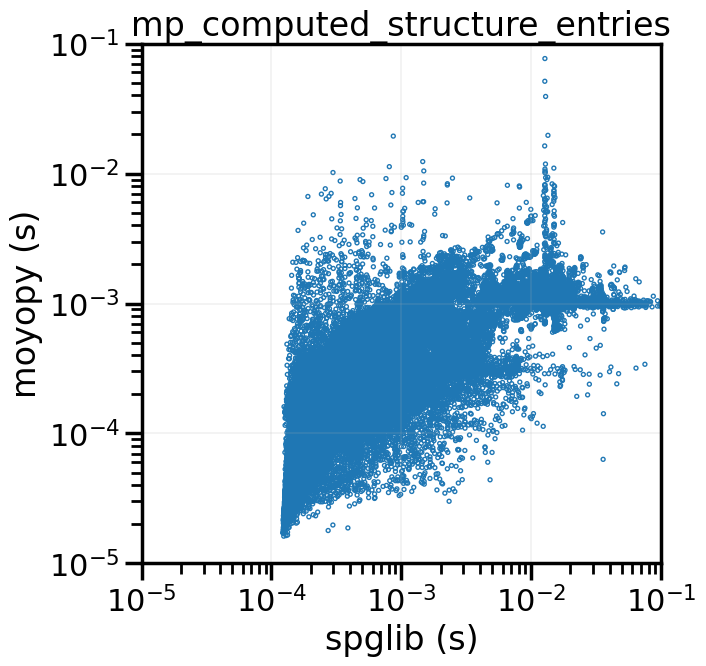

In [13]:
fig, ax = plt.subplots(figsize=(6.75, 6.75))
# df.plot.scatter(x='time_spglib', y='time_moyopy', ax=ax, facecolors='none', edgecolors='C0')
ax.scatter(
    df["time_spglib"], df["time_moyopy"], facecolors="none", edgecolors="C0", s=8, linewidths=1
)
ax.set_xlim(1e-5, 1e-1)
ax.set_ylim(1e-5, 1e-1)
ax.set_xlabel("spglib (s)")
ax.set_ylabel("moyopy (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect("equal")
ax.set_title("mp_computed_structure_entries")
ax.grid()
fig.savefig("mp.png", bbox_inches="tight", pad_inches=0.0, dpi=200)

## Compare detected space group with spglib

moyopy gives the same group number for 98% of Materials Project structures.

In [7]:
len(df_stat[df_stat["jaccard"] < 1]) / len(df_stat)

0.018194392378391655

In [8]:
fig = px.histogram(df_stat[df_stat["jaccard"] < 1], x="jaccard", range_x=[0, 0.9])
fig

In [9]:
df_stat[df_stat["jaccard"] < 1]

,number_moyopy,number_spglib,jaccard,number_moyopy_last,number_spglib_last
material_id,,,,,
mp-1002572,"[1, 3, 18, 18, 18, 58, 58]","[1, 1, 18, 18, 18, 58, 58]",0.750000,58,58
mp-1002574,"[1, 1, 6, 58, 58, 58, 58]","[1, 1, 6, 31, 58, 58, 58]",0.750000,58,58
mp-1003313,"[1, 1, 1, 12, 12, 12, 12]","[1, 1, 1, 8, 12, 12, 12]",0.666667,12,12
mp-1006613,"[1, 1, 1, 1, 1, 1, 43]","[1, 1, 1, 1, 1, 1, 1]",0.500000,43,1
mp-1013760,"[2, 2, 2, 2, 2, 2, 15]","[2, 2, 2, 2, 2, 2, 2]",0.500000,15,2
...,...,...,...,...,...
mp-998627,"[161, 161, 161, 161, 161, 161, 167]","[161, 161, 161, 161, 161, 161, 161]",0.500000,167,161
mp-998781,"[6, 6, 6, 6, 6, 6, 38]","[6, 6, 6, 6, 6, 6, 6]",0.500000,38,6
mp-999337,"[1, 1, 1, 1, 156, 156, 156]","[1, 1, 1, 8, 156, 156, 156]",0.666667,156,156


In [10]:
df_stat[
    (df_stat["number_moyopy_last"] < df_stat["number_spglib_last"]) & (df_stat["jaccard"] < 1)
].sort_values("jaccard")

,number_moyopy,number_spglib,jaccard,number_moyopy_last,number_spglib_last
material_id,,,,,
mp-1978851,"[1, 1, 1, 1, 1, 5, 12]","[1, 1, 1, 1, 1, 1, 15]",0.250000,12,15
mp-775285,"[1, 1, 1, 1, 1, 1, 4]","[1, 1, 1, 1, 1, 1, 19]",0.333333,4,19
mp-1289332,"[1, 1, 1, 1, 1, 1, 6]","[1, 1, 1, 1, 1, 1, 31]",0.333333,6,31
mp-1288374,"[3, 3, 3, 3, 3, 3, 3]","[1, 3, 3, 3, 3, 3, 35]",0.333333,3,35
mp-1274032,"[3, 3, 3, 3, 3, 3, 12]","[3, 3, 3, 3, 3, 3, 13]",0.333333,12,13
mp-1097885,"[2, 2, 2, 2, 2, 2, 2]","[1, 2, 2, 2, 2, 2, 12]",0.333333,2,12
mp-1179946,"[38, 38, 38, 38, 38, 38, 187]","[38, 38, 38, 38, 38, 38, 189]",0.333333,187,189
mp-714929,"[1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 1, 1, 12]",0.333333,2,12
mp-1044171,"[1, 1, 1, 1, 1, 1, 4]","[1, 1, 1, 1, 1, 1, 19]",0.333333,4,19
